In [1]:
import datetime
import tarfile
import json
import bz2
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Filtering tweets from monthly .tar files

In [2]:
#keywords to filter the tweets
keywords=['gmo','gmos','gm food','gm foods','transgenic', 'transgenics','genetically-modified','genetically modified']

# initializing array which will hold the filtered tweets
filteredTweets=[]


# opening the tar file
with tarfile.open('data/TweetDS.tar', 'r') as tar:
    
    # iterating through all files and directories
    for member in tar.getmembers():
        
        #skipping directories
        if member.isdir():
            continue
        
        #looking for the target files json.bz2
        if member.name.endswith('.json.bz2'):
            
            # extracting each file
            file = tar.extractfile(member)
         
            #reading in and decompressing the file
            noBz2 = bz2.decompress(file.read()).decode('utf-8')
            
            # handling each tweet to find the match
            for line in noBz2.splitlines():
                
                #each line is one tweet in json format, therefore loading line by line
                tweet = json.loads(line)

                # making sure the tweet has the fields 'text' and 'created_at'. If not they'll be skipped
                if 'text' not in tweet or 'created_at' not in tweet or tweet['user']['lang'] != 'en':
                    continue

                # Skipping retweets
                if tweet['text'].startswith('RT') and tweet.get('retweeted_status') is not None:
                    continue
                
                # storing fields if present
                tweetTxt = tweet['text']
                created_at = tweet['created_at']

                # Searching matches in text, splitting by words, lower case like keywords
                if any(keyword in tweetTxt.lower().split() for keyword in keywords):                
                    # Add the matching tweet to the list
                    filteredTweets.append({
                        'text': tweetTxt,
                        'created_at': created_at
                    })
                    

                    
#writting the fields from matching tweets to a json output file
with open('myTweets.json', 'w') as output:
    json.dump(filteredTweets, output)

In [3]:
from pyspark.sql.types import *
from pyspark.sql.functions import udf, desc, min, max, date_format, expr, hour, month, dayofweek, count
from pyspark.sql import functions as F #module that includes a variety of functions like to extract features

In [4]:
sc

<SparkContext master=local[*] appName=PySparkShell>

### Loading json data files to pyspark

In [72]:
#funtion to parce the date string
def parseDate(date_str):
    return datetime.datetime.strptime(date_str, '%a %b %d %H:%M:%S %z %Y') # strptime() method creates a datetime object from a string

#user-defined function so that it can be used with spark. Returns timestamp object from the string provided 
parse_date_udf= udf(parseDate, TimestampType())

#reading in all the monthly json files
tweetsDf= spark.read.json('hdfs://localhost:9000/user1/tweet*.json')

# applying udf to column
tweetsDf= tweetsDf.withColumn('created_at', parse_date_udf(tweetsDf['created_at']))

#sorting by timestamp
tweetsDf= tweetsDf.orderBy('created_at')

tweetsDf.printSchema();tweetsDf.show()

root
 |-- created_at: timestamp (nullable = true)
 |-- text: string (nullable = true)

+-------------------+--------------------+
|         created_at|                text|
+-------------------+--------------------+
|2012-01-02 20:09:42|USDA has settled ...|
|2012-01-03 02:41:36|Sounds INSANE. GM...|
|2012-01-03 06:57:08|Petition: Tell th...|
|2012-01-03 12:30:19|Mandatory GMO foo...|
|2012-01-03 14:11:44|http://t.co/TI9oL...|
|2012-01-03 16:10:27|Want to learn mor...|
|2012-01-03 17:53:55|Safety assessment...|
|2012-01-03 18:30:38|GMO labeling effo...|
|2012-01-03 20:04:57|Leaked: US to Sta...|
|2012-01-04 00:22:12|Leaked: US to Sta...|
|2012-01-04 13:37:46|@IPIMCIMCIM  GMOs...|
|2012-01-05 02:42:31|@Kaybaebaeeee gmo...|
|2012-01-05 06:10:28|Apel ws. legislac...|
|2012-01-05 09:36:54|Woman files class...|
|2012-01-05 16:14:15|Leaked: US to Sta...|
|2012-01-05 17:42:20|@harjxo GMO twidd...|
|2012-01-05 19:42:18|@songbirdtiff Yup...|
|2012-01-05 21:07:46|Label GMO food ca...|
|2012-01-0

### EDA

Checking RDD, word count and hashtags

In [73]:
#from pyspark.sql import SparkSession

In [74]:
#spark = SparkSession.builder.getOrCreate()

In [75]:
#converting df to an RDD
tweetsRdd = tweetsDf.rdd

In [76]:
# number of rows (tweets) in the RDD
print(tweetsRdd.count())

3981


In [77]:
#first row of the RDD, then printing timestamp and text separate so that the timestamp is diplayed properly
print(tweetsRdd.first(),'\n\n',tweetsRdd.first()[0],'\n',tweetsRdd.first()[1])

Row(created_at=datetime.datetime(2012, 1, 2, 20, 9, 42), text='USDA has settled upon a superb solution: let the GMO industry conduct its own environmental impact tests. http://t.co/Ed5BbDRb') 

 2012-01-02 20:09:42 
 USDA has settled upon a superb solution: let the GMO industry conduct its own environmental impact tests. http://t.co/Ed5BbDRb


#### checking double spaces

In [78]:
#fileterring tweets with two consecutive white spaces, row per row, and adding up the counts
tweetsRdd.filter(lambda row: "  " in row[1]).count()

335

In [79]:
#triple spaces
tweetsRdd.filter(lambda row: "   " in row[1]).count()

23

In [80]:
# 4 spaces
tweetsRdd.filter(lambda row: "    " in row[1]).count()

6

In [81]:
#9 spaces
tweetsRdd.filter(lambda row: "         " in row[1]).count()

1

Removing extra white spaces

In [82]:
from pyspark.sql import Row

In [83]:
#function to replace consecutive white spaces with a single space
def singleWspace(row):
    return Row(created_at=row.created_at, text=' '.join(row.text.split()))

In [84]:
# mapping function
tweetsRdd= tweetsRdd.map(singleWspace)

In [85]:
#confirmation
tweetsRdd.filter(lambda row: "  " in row[1]).count()

0

In [86]:
tweetsRdd.filter(lambda row: "   " in row[1]).count()

0

In [87]:
tweetsRdd.first()

Row(created_at=datetime.datetime(2012, 1, 2, 20, 9, 42), text='USDA has settled upon a superb solution: let the GMO industry conduct its own environmental impact tests. http://t.co/Ed5BbDRb')

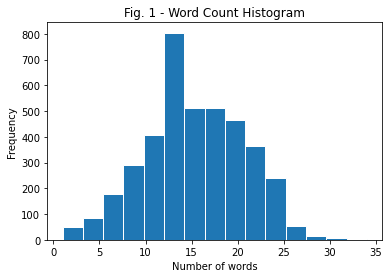

In [88]:
#counting the number of words in each tweet by splitting text
wordCounts= tweetsRdd.map(lambda row: len(row.text.split())).collect()

#plotting the histogram
plt.hist(wordCounts, bins=15, edgecolor='white')
plt.xlabel('Number of words')
plt.ylabel('Frequency')
plt.title('Fig. 1 - Word Count Histogram')
plt.show()

In [89]:
#average number of words per tweet
sum(wordCounts)/len(wordCounts)

15.198944988696308

In [90]:
#standar deviation
np.std(wordCounts)

5.306445242108765

### checking word counts

In [108]:
#extracting all words from the tweets, splitting text with a single space
words= tweetsRdd.flatMap(lambda tweet: tweet[1].split(" ")) # flatMap flattens the RDD after applying the function

#Filtering words with >3 characters
filteredWords= words.filter(lambda word: len(word) > 4)



#counting totals per word, case insensitive
wordCounts = filteredWords.map(lambda word: (word.lower(), 1)).reduceByKey(lambda a, b: a + b) # reduceByKey merges the values for each key using an associative and commutative reduce function

In [109]:
# sorting in descending order
sortedWordCounts= wordCounts.sortBy(lambda x: x[1], ascending=False)

# Taking the top 30 words with the highest counts
topWords= sortedWordCounts.take(30)

# Printing the top words
for word, count in topWords:
    print(word,' - ',count)

labeling  -  452
monsanto  -  293
foods  -  270
label  -  214
about  -  208
&amp;  -  172
organic  -  139
crops  -  129
california  -  117
campaign  -  107
transgenic  -  103
health  -  102
monsanto's  -  100
seeds  -  98
@healthranger  -  96
against  -  87
please  -  86
reject  -  85
study  -  79
support  -  78
don't  -  77
@credomobile  -  75
@youtube  -  72
right  -  71
modified  -  69
safety  -  68
genetically  -  66
their  -  63
@signon  -  63
consumer  -  62


### checking hashtags

In [98]:
#extracting hashtags from the tweets, splitting text with single space, considering words which start with #
hashtagsRdd = tweetsRdd.flatMap(lambda tweet: tweet[1].split(" ")).filter(lambda word: word.startswith("#"))

# counting totals per hashtag, case insensitive with .lower()
hashtagsTotal= hashtagsRdd.map(lambda hashtag: (hashtag.lower(), 1)).reduceByKey(lambda a, b: a + b)

In [99]:
#top 20 hashtags
topHashtags= hashtagsTotal.takeOrdered(20, key=lambda x: -x[1])

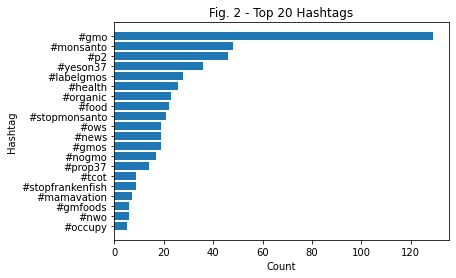

In [100]:
# extracting values to plot
hashtags= [hashtag for (hashtag, count) in topHashtags]
counts= [count for (hashtag, count) in topHashtags]

# Plot the top hashtags
plt.barh(hashtags, counts)
plt.xlabel('Count')
plt.ylabel('Hashtag')
plt.title('Fig. 2 - Top 20 Hashtags')
#plt.figure(figsize=(20, 20))#setting size of plot
plt.gca().invert_yaxis()
plt.show()

## Duplicates

In [110]:
#grouping by text and counting them
duplicates= tweetsDf.groupBy('text').count()

# filtering the rows with count >= 2 
duplicates= duplicates.filter(duplicates['count'] > 1)

duplicates.show()

+--------------------+-----+
|                text|count|
+--------------------+-----+
|People power caus...|    2|
|We are helping cu...|    2|
|At Disney World's...|    2|
|#USDA to Give #Mo...|    2|
|good going Boulde...|    2|
|STOP MONSANTO FRO...|    2|
|#Hungary Destroys...|    2|
|                 GMO|    2|
|Just played: GMO ...|    3|
|Mommy, what does ...|    2|
|Healthy Budget: G...|    5|
|Tell .@BarackObam...|    2|
|GMO updates,Femal...|    2|
|Healthy Budget: G...|    4|
|Pesticide Use Ram...|    2|
+--------------------+-----+



In [14]:
#viewing duplicates fully
duplicates.select('text').show(truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------+
|text                                                                                                                                        |
+--------------------------------------------------------------------------------------------------------------------------------------------+
|People power causes GMO firm to move from Europe to the US. http://t.co/TSaxGffw #GMOs #geneticallymodified #health                         |
|We are helping customers and team members get informed about GMOs via our in-store info centers. Visit one in our stores today.             |
|At Disney World's exhibit, teaching children about GMO agriculture is a "fun activity" http://t.co/EOKSqbGh @TrueFoodAust @TransitionSyd    |
|#USDA to Give #Monsanto’s New GMO Crops Special ‘Speed Approval’: If you thought Monsanto’s lack of testing on their... http://t.co/OzPr4jmL|

In [15]:
tweetsDf.count()

3981

In [16]:
#dropping duplicates, keeping the oldest only
tweetsDf= tweetsDf.dropDuplicates(subset=['text'])

In [17]:
tweetsDf.count()

3960

In [18]:
# oldest and latest dates in df
oldestDate= tweetsDf.select(min('created_at')).first()[0].date()
latestDate= tweetsDf.select(max('created_at')).first()[0].date()

print(' Between\n',oldestDate,'\n and\n',latestDate,'\n')

 Between
 2012-01-02 
 and
 2013-03-01 



In [19]:
#timestamps with greatest count of tweets. Extracting timestamps with module 'functions' and aggregating counts, which are shown in a new column, descendent ordered  
tweetsDf.groupBy('created_at').agg(F.count('*').alias('count')).orderBy(F.desc('count')).show()

+-------------------+-----+
|         created_at|count|
+-------------------+-----+
|2012-11-15 04:15:07|    3|
|2012-11-05 07:56:09|    2|
|2012-09-25 03:20:02|    2|
|2012-05-12 14:49:03|    2|
|2012-10-11 07:00:16|    2|
|2013-01-30 00:36:15|    2|
|2012-11-10 15:17:56|    1|
|2012-01-21 00:31:13|    1|
|2012-06-02 05:22:09|    1|
|2012-10-23 08:55:17|    1|
|2012-10-04 16:30:34|    1|
|2012-01-15 07:33:10|    1|
|2012-02-09 16:52:34|    1|
|2012-09-19 18:04:04|    1|
|2012-11-26 18:55:10|    1|
|2012-02-03 06:43:08|    1|
|2012-07-06 13:15:52|    1|
|2012-10-07 18:37:40|    1|
|2012-06-22 14:34:02|    1|
|2013-01-23 22:30:42|    1|
+-------------------+-----+
only showing top 20 rows



In [20]:
#same as above but excluding seconds, using date_format and extracting date, hours and minutes only
tweetsDf.groupBy(
    F.date_format('created_at', 'yyyy-MM-dd').alias('date'),
    F.date_format('created_at', 'HH').alias('hour'),
    F.date_format('created_at', 'MM').alias('minute')
).agg(F.count('*').alias('count')).orderBy(F.desc('count')).show() #aggregating counts of timestamps (tweets) producing a new column

+----------+----+------+-----+
|      date|hour|minute|count|
+----------+----+------+-----+
|2012-11-07|  14|    11|    7|
|2012-11-06|  19|    11|    6|
|2013-02-16|  16|    02|    6|
|2012-08-23|  19|    08|    6|
|2012-11-06|  16|    11|    6|
|2012-09-15|  22|    09|    6|
|2012-09-13|  03|    09|    6|
|2012-04-03|  04|    04|    5|
|2012-10-03|  19|    10|    5|
|2012-09-19|  21|    09|    5|
|2012-09-28|  15|    09|    5|
|2012-09-29|  17|    09|    5|
|2012-10-18|  03|    10|    5|
|2012-09-23|  17|    09|    5|
|2012-09-28|  17|    09|    5|
|2012-11-07|  17|    11|    4|
|2012-11-03|  01|    11|    4|
|2013-01-13|  16|    01|    4|
|2012-08-17|  19|    08|    4|
|2012-11-08|  17|    11|    4|
+----------+----+------+-----+
only showing top 20 rows



In [21]:
#same as above but also excluding minutes, using date_format and extracting date and hours only
tweetsDf.groupBy(
    F.date_format('created_at', 'yyyy-MM-dd').alias('date'),
    F.date_format('created_at', 'HH').alias('hour')
).agg(F.count('*').alias('count')).orderBy(F.desc('count')).show() #aggregating counts of timestamps (tweets) producing a new column

+----------+----+-----+
|      date|hour|count|
+----------+----+-----+
|2012-11-07|  14|    7|
|2012-09-13|  03|    6|
|2012-08-23|  19|    6|
|2012-11-06|  19|    6|
|2012-11-06|  16|    6|
|2012-09-15|  22|    6|
|2013-02-16|  16|    6|
|2012-09-23|  17|    5|
|2012-09-28|  15|    5|
|2012-09-29|  17|    5|
|2012-09-28|  17|    5|
|2012-04-03|  04|    5|
|2012-10-03|  19|    5|
|2012-10-18|  03|    5|
|2012-09-19|  21|    5|
|2012-08-18|  20|    4|
|2012-03-17|  14|    4|
|2012-02-16|  22|    4|
|2012-10-06|  15|    4|
|2012-10-06|  16|    4|
+----------+----+-----+
only showing top 20 rows



### Dates without tweets (~missing dates)

In [22]:
print(' Between\n',oldestDate,'\n and\n',latestDate,'\n')

#converting dates to Unix timestamps -> int() cannot be datetime.date
oldestDate= int(oldestDate.strftime("%s"))
latestDate= int(latestDate.strftime("%s"))

#generating the list of dates. 86400 s/day
timeRange= spark.range(start=oldestDate, end=latestDate, step=86400).selectExpr("to_date(from_unixtime(id)) as date")



#Listing missing dates with anti-join between the date range and the 'created_at' column. 
missingDates= timeRange.join(tweetsDf, timeRange.date == tweetsDf.created_at.cast(DateType()), 'leftanti') # leftanti selects the rows from the left df that do not have a matching key from the right df


print(" there are missing dates->",missingDates.count());missingDates.show()

 Between
 2012-01-02 
 and
 2013-03-01 

 there are missing dates-> 5
+----------+
|      date|
+----------+
|2012-02-05|
|2012-12-28|
|2012-12-29|
|2012-12-30|
|2012-12-31|
+----------+



#### Checking number of natural hours per day that hold tweets

In [23]:
#grouping by date and count unique hours. Extranting features with module 'functions'. Counts the unique hours per day and aggregates the totals in a new column
hourlyPerDay = tweetsDf.groupBy(F.to_date('created_at').alias('date')).agg(F.countDistinct(F.hour('created_at')).alias('uniqueHourCount'))

hourlyPerDay.orderBy(desc('uniqueHourCount')).show() # ORDENADOS DESCENDENTEMENTE PARA VER LO Q SERIA LA MEJOR PARTE, QUE EN REALIDAD EVIDENCIA QUE NO ES BUENA, AUNQ EL NUMERO DE TWEETS NO ES ALTO DE PRIMERAS

+----------+---------------+
|      date|uniqueHourCount|
+----------+---------------+
|2012-09-26|             20|
|2012-09-24|             18|
|2012-10-05|             17|
|2012-09-28|             17|
|2012-09-20|             17|
|2012-10-03|             17|
|2012-10-21|             16|
|2012-11-07|             16|
|2012-09-27|             16|
|2012-10-27|             16|
|2012-11-28|             15|
|2012-10-09|             15|
|2012-11-06|             15|
|2012-10-11|             15|
|2012-10-24|             15|
|2012-09-21|             14|
|2012-11-14|             14|
|2012-06-24|             14|
|2012-10-16|             14|
|2012-09-23|             14|
+----------+---------------+
only showing top 20 rows



In [24]:
#checking percentiles
hourlyPerDay.toPandas().describe(percentiles=[0.25, 0.5, 0.75])

,uniqueHourCount
count,420.000000
mean,7.176190
std,3.415171
min,1.000000
25%,5.000000
50%,7.000000
75%,9.000000
max,20.000000


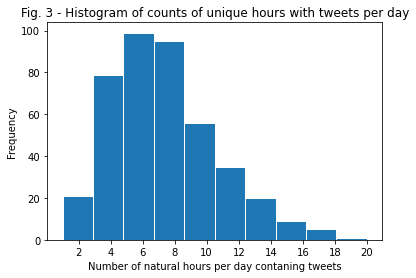

In [45]:
#transforming to pandas for the histogram 
plt.hist(hourlyPerDay.toPandas()['uniqueHourCount'], bins=10, edgecolor='white')

#Arranging axis labels, ticks, title
plt.xlabel('Number of natural hours per day contaning tweets')
plt.ylabel('Frequency')
plt.xticks(np.arange(2,21,2))
plt.title('Fig. 3 - Histogram of counts of unique hours with tweets per day')

plt.show()

## Basic plots

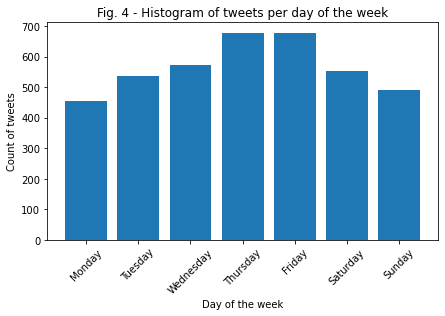

In [46]:
#extracting each of the days of the week
tweetsDf= tweetsDf.withColumn('day_of_week', dayofweek('created_at'))

# counting number of tweets by day of the week by adding a new column
tweetCounts= tweetsDf.groupBy('day_of_week').agg(count('*').alias('count'))


dayLabels= ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(7, 4))#setting size of plot
plt.bar(tweetCounts.toPandas()['day_of_week'], tweetCounts.toPandas()['count'])#need to convert to pandas

#Arranging axis labels, ticks, title
plt.xlabel('Day of the week')
plt.ylabel('Count of tweets')
plt.title('Fig. 4 - Histogram of tweets per day of the week')
plt.xticks(range(1, 8), dayLabels, rotation=45)
plt.show()

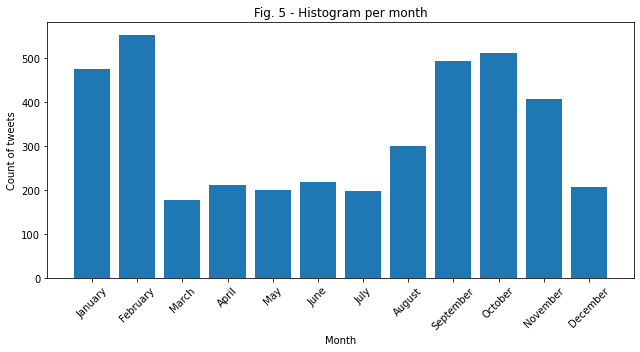

In [47]:
# extracting months
tweetsDf= tweetsDf.withColumn('month', month('created_at'))

#same as before adding a new column with counts
tweetCounts= tweetsDf.groupBy('month').agg(count('*').alias('count'))



monthLabels= ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']


plt.figure(figsize=(9, 5))
plt.bar(tweetCounts.toPandas()['month'], tweetCounts.toPandas()['count'])
plt.xlabel('Month')
plt.ylabel('Count of tweets')
plt.title('Fig. 5 - Histogram per month')
plt.xticks(range(1, 13), monthLabels,rotation=45)
plt.tight_layout()
plt.show()

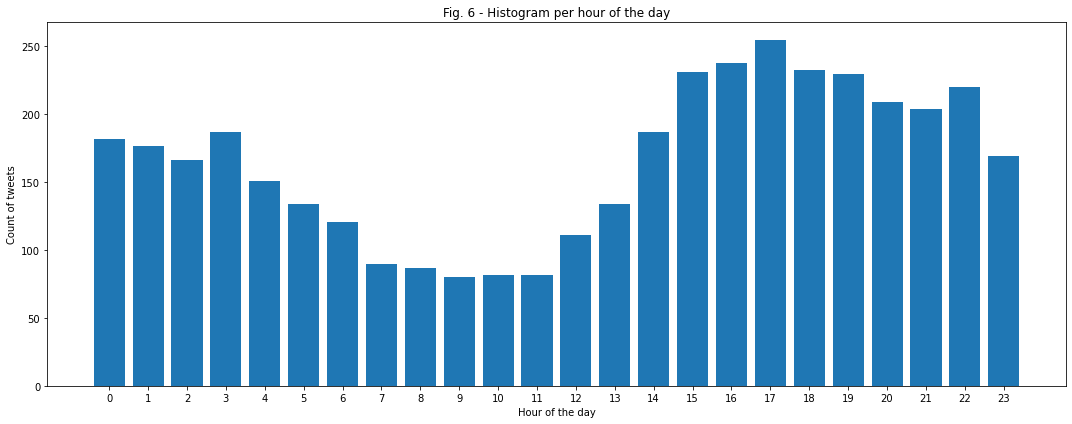

In [48]:
#extracting each of the 24 hours of a day
tweetsDf= tweetsDf.withColumn('hour_of_day', hour('created_at'))

#adding column with counts
tweetCounts= tweetsDf.groupBy('hour_of_day').agg(count('*').alias('count'))


plt.figure(figsize=(15, 6))
plt.bar(tweetCounts.toPandas()['hour_of_day'], tweetCounts.toPandas()['count'])
plt.xlabel('Hour of the day')
plt.ylabel('Count of tweets')
plt.title('Fig. 6 - Histogram per hour of the day')
plt.xticks(range(24))
plt.tight_layout()
plt.show()

## cleaning RDD 

In [128]:
import re # regular expressions
import nltk
from pyspark.ml.feature import StopWordsRemover
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# nltk.download('stopwords')
# nltk.download('punkt')

[nltk_data] Downloading package stopwords to /home/hduser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/hduser/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:

# stopwords for English
stopwords = set(stopwords.words('english'))

In [132]:
# Cleaning up tweets
def clean_text(row):
    text = row.text

    # removing links
    text = re.sub(r'http\S+', '', text)

    # hashtags
    text = re.sub(r'#\w+', '', text)
    
    # user mentions -starting with @-
    text = re.sub(r'@\w+', '', text)

    # special characters 
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
    
    # in case there are single characters
    text = re.sub(r'\b\w\b', '', text)

    
    #tokenizing text into words
    tokens = word_tokenize(text)

    # removing stopwords and making it lower case
    woTokens = [token.lower() for token in tokens if token.lower() not in stopwords]

    
    #joining tokens back
    cleaned_text = ' '.join(woTokens)


    return Row(created_at=row.created_at, text=cleaned_text)





In [ ]:
# applying function to the RDD
cleanedRdd = tweetsRdd.map(clean_text)

In [133]:
cleanedRdd.count()

3981

In [134]:
cleanedRdd.first()

Row(created_at=datetime.datetime(2012, 1, 2, 20, 9, 42), text='usda settled upon superb solution let gmo industry conduct environmental impact tests')

### Assigning a sentiment score

In [136]:
#!pip install textblob

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 636.8/636.8 KB 473.8 kB/s eta 0:00:00m eta 0:00:010:00:01


In [137]:
from textblob import TextBlob

In [143]:
#function to assign a sentiment score
def sentimentScore(row):
    text = row.text

    # creating TextBlob object
    blob = TextBlob(text)

    
    #Getting scores
    polarity = blob.sentiment.polarity

    
    
    # updating rows with sentiment score
    return Row(created_at=row.created_at, text=row.text, sentimentScore=polarity)



In [144]:
#applying function
sentimentRdd = cleanedRdd.map(sentimentScore)

In [145]:
sentimentRdd.first()

Row(created_at=datetime.datetime(2012, 1, 2, 20, 9, 42), text='usda settled upon superb solution let gmo industry conduct environmental impact tests', sentimentScore=1.0)

In [151]:
# number of tweets
tweetsNumber = sentimentRdd.count()


#tweets with score > 0.3 (+ sentiment)
positiveTweets = sentimentRdd.filter(lambda row: row.sentimentScore > 0.33).count()

# tweets with score < -0.3 (- sentiment)
negativeTweets = sentimentRdd.filter(lambda row: row.sentimentScore < -0.33).count()


# proportions
positivePercent = (positiveTweets / tweetsNumber)*100
negativePercent = (negativeTweets / tweetsNumber)*100

In [153]:
print(round(positivePercent,1),'% of tweets with positive sentiment')
print(round(negativePercent,1),'% of tweets with negative sentiment')
print(round(100-positivePercent-negativePercent,1),'% of tweets with neutral sentiment')

13.1 % of tweets with positive sentiment
5.8 % of tweets with negative sentiment
81.1 % of tweets with neutral sentiment


In [171]:
from pyspark.sql.functions import to_date, avg, format_number

In [186]:
sentimentDf = spark.createDataFrame(sentimentRdd, ['created_at', 'text'])

#grouping df by date. Get average score per day and sort by date
averageScores = sentimentDf.groupBy(to_date('created_at').alias('date')).agg(format_number(avg('sentimentScore'),2).alias('averageScore')).orderBy(F.asc('date'))

averageScores.show()

+----------+------------+
|      date|averageScore|
+----------+------------+
|2012-01-02|        1.00|
|2012-01-03|       -0.13|
|2012-01-04|        0.00|
|2012-01-05|       -0.00|
|2012-01-06|        0.08|
|2012-01-07|       -0.03|
|2012-01-08|        0.00|
|2012-01-09|        0.08|
|2012-01-10|       -0.04|
|2012-01-11|       -0.14|
|2012-01-12|       -0.14|
|2012-01-13|       -0.04|
|2012-01-14|       -0.12|
|2012-01-15|       -0.02|
|2012-01-16|        0.13|
|2012-01-17|       -0.01|
|2012-01-18|       -0.04|
|2012-01-19|       -0.03|
|2012-01-20|        0.21|
|2012-01-21|       -0.01|
+----------+------------+
only showing top 20 rows



In [214]:
#converting to pandas
averageScoresPd = averageScores.toPandas()
averageScoresPd['averageScore']= averageScoresPd['averageScore'].astype(float).round(decimals=2) #averageScore needs to be reconverted as float so that it is ordered in the y axis
averageScoresPd

,date,averageScore
0,2012-01-02,1.00
1,2012-01-03,-0.13
2,2012-01-04,0.00
3,2012-01-05,-0.00
4,2012-01-06,0.08
...,...,...
415,2013-02-25,0.05
416,2013-02-26,-0.07
417,2013-02-27,0.02
418,2013-02-28,0.17


In [215]:
averageScoresPd.describe()

,averageScore
count,420.000000
mean,0.061405
std,0.111380
min,-0.200000
25%,-0.010000
50%,0.050000
75%,0.120000
max,1.000000


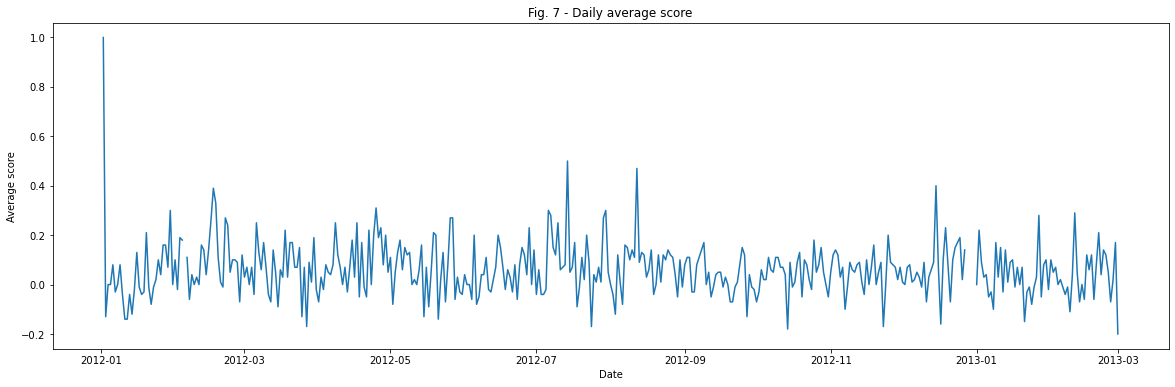

In [284]:
# Plot the average score per day
plt.figure(figsize=(20, 6))  # Set the figure size

# Plotting scores
plt.plot(averageScoresPd['date'], averageScoresPd['averageScore']) 

# Formatting the plot
plt.xlabel('Date')
plt.ylabel('Average score')
plt.title('Fig. 7 - Daily average score')
plt.show()

Adding missing dates and filling scores with NaNs

In [254]:
len(averageScoresPd)

425

In [227]:
#setting date column as index
averageScoresPd.set_index('date', inplace=True)

In [241]:
# generating a date range 
dateRange= pd.date_range(start=averageScoresPd.index.min(), end=averageScoresPd.index.max(), freq='D')#daily frequence

# reindexing df with the date range. Missing scores filled with NaN
averageScoresPd= averageScoresPd.reindex(dateRange)



#reseting index to include the 'date' column
averageScoresPd.reset_index(inplace=True)
averageScoresPd.rename(columns={'index': 'date'}, inplace=True)

# Sort the DataFrame by date
averageScoresPd.sort_values('date', inplace=True)



In [253]:
averageScoresPd.isnull().sum()

date            0
averageScore    5
dtype: int64

In [246]:
averageScoresPd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 425 entries, 0 to 424
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          425 non-null    datetime64[ns]
 1   averageScore  420 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 10.0 KB


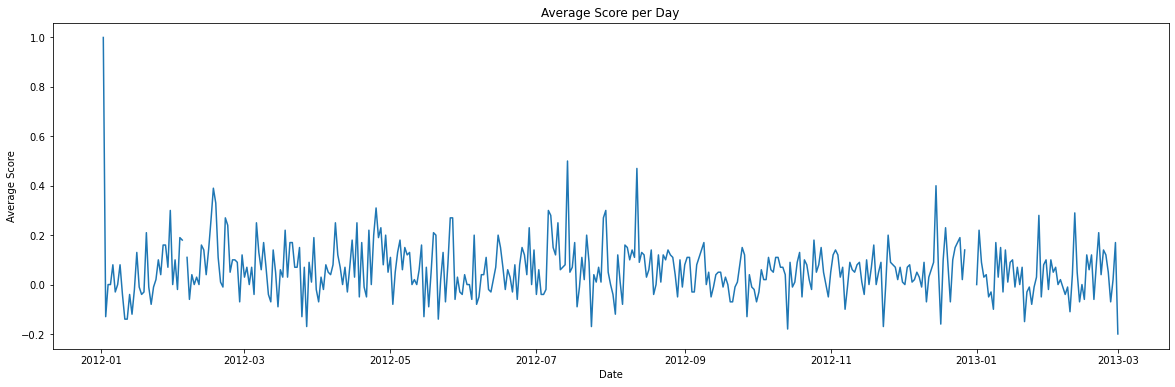

In [256]:
# Plot the average score per day
plt.figure(figsize=(20, 6))  # Set the figure size

# Plotting scores
plt.plot(averageScoresPd['date'], averageScoresPd['averageScore']) 

# Formatting the plot
plt.xlabel('Date')
plt.ylabel('Average Score')
plt.title('Average Score per Day')
plt.show()